In [1]:
import numpy as np
import pandas as pd
import datetime

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
price_df = pd.read_csv('prices-split-adjusted.csv', index_col = 'date', parse_dates=True)

In [4]:
price_df.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [5]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB


In [6]:
# Filtering apple stocks data from adjusted prices file
apl_stock = price_df.query("symbol == 'AAPL'")

In [7]:
apl_stock.shape

(1762, 6)

<AxesSubplot:xlabel='date'>

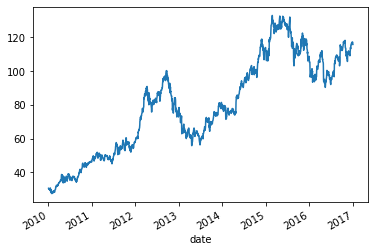

In [8]:
# Plotting closing prices of apple stocks
apl_stock['close'].plot()

In [9]:
# Filtering closing prices of apple stocks
apl_close  = apl_stock.filter(['close']).values

In [10]:
apl_close

array([[ 30.57285686],
       [ 30.62571329],
       [ 30.13857071],
       ...,
       [116.760002  ],
       [116.730003  ],
       [115.82      ]])

In [11]:
# Scaling the data

from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))
apl_scaled=scaler.fit_transform(apl_close)

apl_scaled

array([[0.02971784],
       [0.03021854],
       [0.02560389],
       ...,
       [0.84616011],
       [0.84587593],
       [0.83725556]])

In [12]:
# Time period. Model prediction will be given on the basis of stock price for so many days.

period = 60

In [13]:
# Spiltting the data into training and testing dataset
training_size=int(len(apl_scaled)*0.65)
test_size=len(apl_scaled)-training_size
train_data,test_data=apl_scaled[0:training_size,:],apl_scaled[training_size-60:,:]

In [14]:
x_train = []
y_train= []

In [15]:
# Preparing target and feature sets

from tqdm import tqdm
for i in tqdm(range(period, len(train_data))):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

100%|██████████████████████████████████████████████████████████████████████████| 1085/1085 [00:00<00:00, 543576.19it/s]


In [16]:
len(x_train), len(y_train)

(1085, 1085)

In [17]:
# Converting features and targets from list to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [18]:
# Reshaping features into the size that is convinient for LSTM model training

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1085, 60, 1)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [20]:
# Building Stacked LSTM model
model = Sequential(
    [
        LSTM(50, input_shape=(x_train.shape[1], 1), return_sequences=True),
        LSTM(50, return_sequences=False),
        Dense(25),
        Dense(1)
    ]
)

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [23]:
# Training the model
model.fit(x_train, y_train,
         batch_size=1,
         epochs=1)

1085/1085 [==============================] - 17s 12ms/step - loss: 0.0017


In [24]:
x_test, y_test = [], apl_close[training_size:, :]

for i in range(period, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [25]:
len(x_test), len(y_test)

(617, 617)

In [26]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [27]:
# Making Predictions
pred = model.predict(x_test)

In [28]:
# Converting predictions from scaled values to original values
pred = scaler.inverse_transform(pred)

In [29]:
# Computing RMSE loss
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, pred, squared = False)

2.9903513467388954

In [30]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

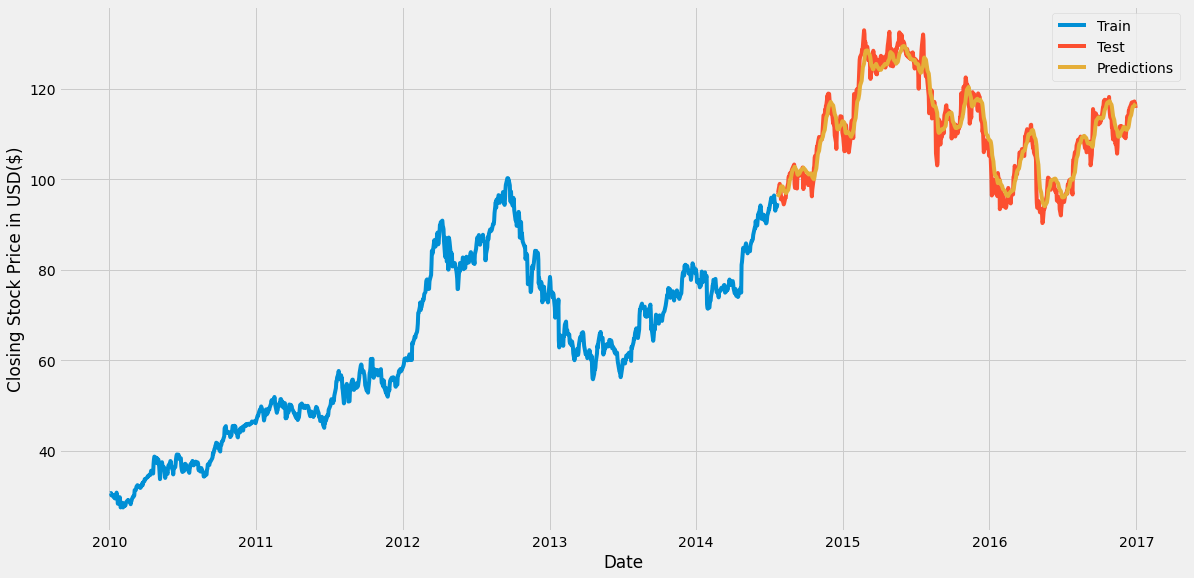

In [31]:
# Preparing data for plotting
train = apl_stock[:training_size]
test = apl_stock[training_size:]
test['pred'] = pred

# Plotting model predictions
plt.figure(figsize=(18,9))
plt.plot(train['close'])
plt.plot(test[['close', 'pred']])
plt.xlabel('Date')
plt.ylabel('Closing Stock Price in USD($)')
plt.legend(['Train', 'Test', 'Predictions'])

In [32]:
# Original vs prediction stock values
test[['close', 'pred']]

,close,pred
date,,
2014-07-23,97.190002,96.128998
2014-07-24,97.029999,96.307404
2014-07-25,97.669998,96.597885
2014-07-28,99.019997,96.981796
2014-07-29,98.379997,97.502144
...,...,...
2016-12-23,116.519997,116.068192
2016-12-27,117.260002,116.291412
2016-12-28,116.760002,116.511734
